## Steps to Implement Faster RCNN
1. Import requires libraries and load data
2. Data Preprocessing
3. Defining model architecture
4. Testing the model

FASTER RCNN Implementation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Required Libraries and Load the Dataset

In `torchvision.models.detection` module. `fasterrcnn_resnet50_fpn` is a pre-trained model provided by PyTorch's torchvision library.
- It uses the Faster R-CNN (Region-based Convolutional Neural Networks) architecture with a ResNet-50 backbone and Feature Pyramid Network (FPN).
- The ResNet-50 backbone is used for feature extraction, and FPN enhances the feature extraction
- This model is commonly used for object detection tasks, where the goal is to detect and classify objects within an image.


`import FastRCNNPredictor`
This imports the FastRCNNPredictor class from torchvision.models.detection.faster_rcnn.
- The FastRCNNPredictor is a module that serves as the final classifier and bounding box regressor in the Faster R-CNN architecture.
-applies a Region Proposal Network (RPN) to propose candidate object bounding boxes.
- It then predicts the classes of the objects and refines their bounding box coordinates.

In [2]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
# unzip the data
!unzip '/content/drive/MyDrive/colabdataset/train_naive_approch.zip'

Archive:  /content/drive/MyDrive/colabdataset/train_naive_approch.zip
   creating: train_naive_approch/
   creating: train_naive_approch/images/
  inflating: train_naive_approch/images/2007_000027.jpg  
  inflating: train_naive_approch/images/2007_000032.jpg  
  inflating: train_naive_approch/images/2007_000033.jpg  
  inflating: train_naive_approch/images/2007_000039.jpg  
  inflating: train_naive_approch/images/2007_000042.jpg  
  inflating: train_naive_approch/images/2007_000061.jpg  
  inflating: train_naive_approch/images/2007_000063.jpg  
  inflating: train_naive_approch/images/2007_000068.jpg  
  inflating: train_naive_approch/images/2007_000121.jpg  
  inflating: train_naive_approch/images/2007_000123.jpg  
  inflating: train_naive_approch/images/2007_000129.jpg  
  inflating: train_naive_approch/images/2007_000170.jpg  
  inflating: train_naive_approch/images/2007_000175.jpg  
  inflating: train_naive_approch/images/2007_000187.jpg  
  inflating: train_naive_approch/images/200

## Data Preprocessing

In [4]:
# reading csv file
data = pd.read_csv('/content/drive/MyDrive/colab dataset/train.csv')
data.head(20)

,filename,class,xmin,xmax,ymin,ymax
0,2007_000027.jpg,person,174,349,101,351
1,2007_000032.jpg,aeroplane,104,375,78,183
2,2007_000032.jpg,aeroplane,133,197,88,123
3,2007_000032.jpg,person,195,213,180,229
4,2007_000032.jpg,person,26,44,189,238
5,2007_000033.jpg,aeroplane,9,499,107,263
6,2007_000033.jpg,aeroplane,421,482,200,226
7,2007_000033.jpg,aeroplane,325,411,188,223
8,2007_000039.jpg,tvmonitor,156,344,89,279
9,2007_000042.jpg,train,263,500,32,295


In [5]:
data['class'].unique()

array(['person', 'aeroplane', 'tvmonitor', 'train', 'boat', 'dog',
       'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable',
       'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus',
       'pottedplant'], dtype=object)

In [6]:
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data['class']= label_encoder.fit_transform(data['class'])

In [7]:
data

,filename,class,xmin,xmax,ymin,ymax
0,2007_000027.jpg,14,174,349,101,351
1,2007_000032.jpg,0,104,375,78,183
2,2007_000032.jpg,0,133,197,88,123
3,2007_000032.jpg,14,195,213,180,229
4,2007_000032.jpg,14,26,44,189,238
...,...,...,...,...,...,...
195,2007_001185.jpg,10,204,500,223,375
196,2007_001185.jpg,4,452,500,131,253
197,2007_001225.jpg,11,100,303,212,414
198,2007_001239.jpg,11,108,320,60,160


In [8]:

# we will not detect small objects like platelets as Faster RCNN is not good for it
#If the xmax value is greater than xmin value by at least 20 units, ensuring that the width of the bounding box is at least 20 pixels.
#if the ymax value is greater than ymin value by at least 20 units, ensuring that the height of the bounding box is at least 20 pixels.
#This line filters out all rows where the bounding box's width or height is less than or equal to 20 pixels.
data = data.loc[(data['xmax'] > data['xmin'] + 20) | (data['ymax'] > data['ymin'] + 20)]

In [9]:
# defining required transformations
from torchvision import transforms as TF #brings in the transforms module from the torchvision library,

transform = TF.Compose([                                 #composes several transforms together.
    TF.Resize((224, 224)),
    TF.ToTensor()                                        #converts a PIL image or a NumPy ndarray into a PyTorch tensor.
])

In [10]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

**Example of collate_fn**

In [11]:
# defining class to load data
class Dataset(torch.utils.data.Dataset):  # Defines a new class BloodCellDataset that inherits from PyTorch's Dataset
    def __init__(self, root, transforms=None):     # Initializer or constructor for the BloodCellDataset class ,root is the path to the directory where the images are stored.
        self.root = root                           # we store the root directory path in the instance variable self.root
        self.transforms = transforms
        # load all image files
        self.imgs = data.filename.unique()     #image_names column contains the names of image files,It extracts the unique image names and stores them in the instance variable self.imgs.

    def __getitem__(self, idx): #This method is required by the PyTorch Dataset interface. It retrieves the idx-th sample from the dataset
        # load images
        img_name = self.imgs[idx] #This line gets the image filename at the given index idx.
        img_path = os.path.join(self.root, img_name)#It constructs the full path to the image by joining the root directory and the image filename.
        img = Image.open(img_path)#his line uses the PIL library to open the image file

        num_objs = data[data['filename'] == img_name].shape[0] #This counts the number of objects (cells) in the current image by filtering the data DataFrame
        boxes = []
        cell_type = []
        for i in range(num_objs):
            xmin = data[data['filename'] == img_name]['xmin'].iloc[i] # xmin
            xmax = data[data['filename'] == img_name]['xmax'].iloc[i] # xmax
            ymin = data[data['filename'] == img_name]['ymin'].iloc[i] # ymin
            ymax = data[data['filename'] == img_name]['ymax'].iloc[i] # ymax
            target = data[data['filename'] == img_name]['class'].iloc[i] # Target-WBC or RBC
            boxes.append([xmin, ymin, xmax, ymax])
            cell_type.append(target)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(cell_type, dtype=torch.int64)

        target = {} #These lines create a dictionary to store the tensors for bounding boxes and labels
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
            boxes[:, 0] = boxes[:, 0] * (224/640) # we have to resize the boxes as we are resizing image
            boxes[:, 2] = boxes[:, 2] * (224/640)
            boxes[:, 1] = boxes[:, 1] * (224/480)
            boxes[:, 3] = boxes[:, 3] * (224/480)

        return img, target


    def __len__(self):
        return len(self.imgs)


In [12]:
dataset = Dataset('/content/drive/MyDrive/colab dataset/images', transforms=transform)

DataLoader is configured to load data from dataset in batches of 8 samples per batch without shuffling the order of the data.
It uses a collate_fn for collating samples into batches

In [13]:
# defining data loader
data_loader = torch.utils.data.DataLoader(     #initializes a new DataLoader object from the PyTorch torch.utils.data
    dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [14]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [15]:
batch_x[0].shape

torch.Size([3, 224, 224])

In [16]:
batch_y[0]

{'boxes': tensor([[ 60.9000,  47.1333, 122.1500, 163.8000]]),
 'labels': tensor([14])}

In [17]:
len(batch_y[0]['boxes'])

1

In [18]:
batch_y[0]['boxes'][0]

tensor([ 60.9000,  47.1333, 122.1500, 163.8000])

- Original shape of batch_x[0] is (C, H, W)
- `np.transpose(batch_x[0], (1, 2, 0))`, the shape would be (H, W, C)

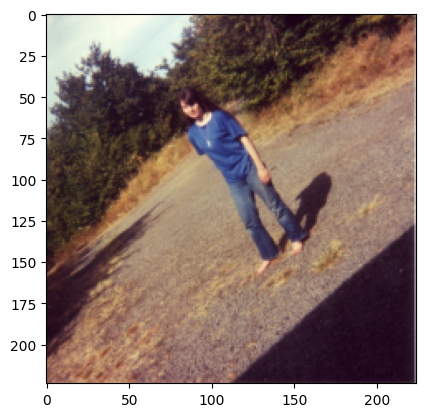

In [19]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

- `(x1, y1)`: The bottom-left corner of the rectangle.
- `x2-x1`: The width of the rectangle, calculated by subtracting the x-coordinate of the bottom-left corner from the x-coordinate of the top-right corner.
- `y2-y1`: The height of the rectangle, calculated by subtracting the -y-coordinate of the bottom-left corner from the y-coordinate of the top-right corner.
- fc='none': This sets the face color (interior) of the rectangle to 'none', making the rectangle transparent inside.
- ec=color: This sets the edge color of the rectangle to whatever color is specified.

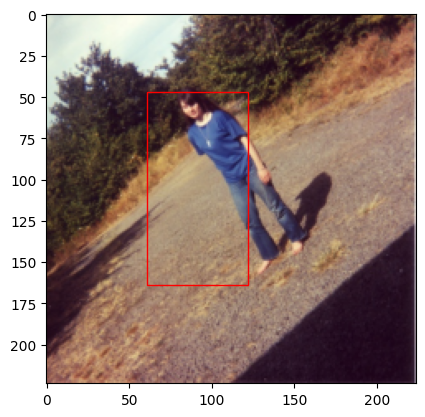

num person tensor(1)
num aeroplane tensor(0)


In [20]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if batch_y[0]['labels'][i] == 14:
        color = 'red'
    elif batch_y[0]['labels'][i] == 0:
        color = 'blue'

    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('num person', (batch_y[0]['labels'] == 14).sum())
print('num aeroplane', (batch_y[0]['labels'] == 2).sum())

## Defining the model

In [21]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 68.0MB/s]


In [22]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

- When fine-tuning an object detection model for a dataset with a different number of classes, it's necessary to replace the classifier head (cls_score layer) with a new one that matches the target number of classes.
- To do this, one must know the size of the input features (in_features) that feed into this layer to construct a new classifier with the appropriate dimensions.
-
```in_features = model.roi_heads.box_predictor.cls_score.in_features```
- This line extracts the number of input features for the classifier layer, which is crucial for creating a new classifier that matches the architecture.

In [23]:
num_classes = 21   # one class for background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [24]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))

In [25]:
output

[{'boxes': tensor([[9.2156e+01, 1.0165e+02, 1.1132e+02, 1.8516e+02],
          [8.1808e+01, 6.9036e+01, 1.1211e+02, 1.8354e+02],
          [0.0000e+00, 1.5431e+02, 1.0307e+02, 2.0287e+02],
          [1.9243e+02, 6.4747e+01, 2.2400e+02, 1.7633e+02],
          [1.9321e+02, 1.2202e+02, 2.1873e+02, 1.8472e+02],
          [5.7448e+00, 4.3547e+01, 1.5499e+02, 7.6008e+01],
          [8.5177e+01, 9.9383e+01, 1.1225e+02, 1.3963e+02],
          [1.1964e+01, 1.7868e+02, 2.5987e+01, 1.9349e+02],
          [9.0767e+01, 1.3697e+02, 1.0156e+02, 1.7896e+02],
          [1.0245e+02, 1.2629e+02, 1.8933e+02, 2.0391e+02],
          [1.1899e+02, 9.2804e+01, 2.2400e+02, 1.9631e+02],
          [1.8910e+02, 1.2905e+02, 2.1967e+02, 1.5587e+02],
          [1.8630e+02, 1.6423e+01, 2.2400e+02, 1.4357e+02],
          [9.0994e+01, 1.0130e+02, 1.1002e+02, 1.2610e+02],
          [4.1306e-02, 9.1105e+01, 8.7458e+01, 1.0524e+02],
          [0.0000e+00, 1.2001e+02, 9.4328e+01, 2.2400e+02],
          [1.7970e+02, 7.4326e+

- High Score (close to 1): The model is highly confident that the detected object within the bounding box correctly matches the predicted label. For example, if the model predicts a bounding box around an area of the image with a score of 0.95 and the label 'cat', it is very confident that the object within that bounding box is indeed a cat.

- Low Score (close to 0): The model has low confidence in its prediction. A low score suggests that the model is unsure about the object within the bounding box or even whether the detected region contains any object of interest at all.

In [26]:
number_of_boxes = len(output[0]['boxes'])
print(number_of_boxes)

100


In [27]:
!nvidia-smi

Sun Feb 25 16:49:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
# transfer model to GPU
model = model.to("cuda")

In [29]:
# define optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [30]:
# set model to train
model.train()


# train model
for epoch in range(2):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = list(image.to("cuda") for image in batch_x)
        batch_y = [{k: v.to("cuda") for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.6956427931785584 for classification and 0.15835065692663192 for regression 
Training loss for epoch 2 is 0.27169052362442014 for classification and 0.16644738465547562 for regression 


## Model Evaluation

In [63]:
# selecting one image from dataset
image = Image.open('/content/drive/MyDrive/colab dataset/images/2007_000032.jpg')
image = transform(image)

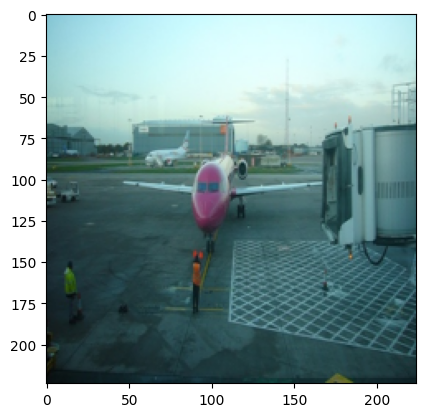

In [64]:
plt.imshow(np.transpose(image, (1, 2, 0)))

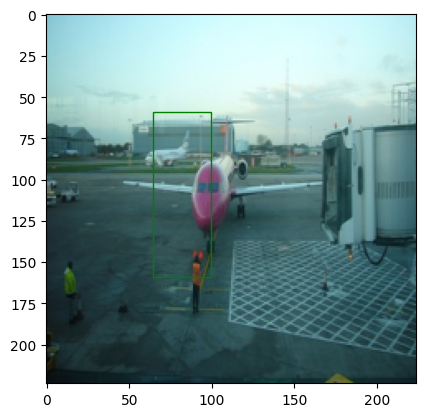

num aeroplane tensor(1)
num person tensor(0)


In [68]:
# check model on one image
model.eval()
output = model(image.unsqueeze(dim=0).cuda()) # passing single image
output = [{k: v.to("cpu") for k, v in t.items()} for t in output]

# plot bounding box
plt.axes()
plt.imshow(np.transpose(image, (1, 2, 0)))
for i in range(len(output[0]['boxes'])):
    bbox = output[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if output[0]['labels'][i] == 1:
        color = 'red'
    elif output[0]['labels'][i] == 2:
        color = 'blue'
    else:
        color = 'green'
    x1 = x1.detach().numpy()
    y1 = y1.detach().numpy()
    x2 = x2.detach().numpy()
    y2 = y2.detach().numpy()
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('num aeroplane', (output[0]['labels'] == 1).sum()+1)
print('num person', (output[0]['labels'] == 2).sum())
